In [1]:
import pandas as pd

## Загрузка данных

In [22]:
aliases = pd.read_csv('data/Aliases.csv')
emailreceivers = pd.read_csv('data/EmailReceivers.csv')
emails = pd.read_csv('data/Emails.csv')
persons = pd.read_csv('data/Persons.csv')

In [7]:
emails.columns

Index(['Id', 'DocNumber', 'MetadataSubject', 'MetadataTo', 'MetadataFrom',
       'SenderPersonId', 'MetadataDateSent', 'MetadataDateReleased',
       'MetadataPdfLink', 'MetadataCaseNumber', 'MetadataDocumentClass',
       'ExtractedSubject', 'ExtractedTo', 'ExtractedFrom', 'ExtractedCc',
       'ExtractedDateSent', 'ExtractedCaseNumber', 'ExtractedDocNumber',
       'ExtractedDateReleased', 'ExtractedReleaseInPartOrFull',
       'ExtractedBodyText', 'RawText'],
      dtype='object')

In [138]:
data = pd.DataFrame(emails[['MetadataSubject', 'ExtractedBodyText']])
data.columns = ['subject', 'body']
data.fillna('', inplace=True)

In [139]:
data.head(20)

,subject,body
0,WOW,
1,H: LATEST: HOW SYRIA IS AIDING QADDAFI AND MOR...,"B6\nThursday, March 3, 2011 9:45 PM\nH: Latest..."
2,CHRIS STEVENS,Thx
3,CAIRO CONDEMNATION - FINAL,
4,H: LATEST: HOW SYRIA IS AIDING QADDAFI AND MOR...,"H <hrod17@clintonemail.com>\nFriday, March 11,..."
5,MEET THE RIGHT-WING EXTREMIST BEHIND ANTI-MUSL...,Pis print.\n-•-...-^\nH < hrod17@clintonernail...
6,"ANTI-MUSLIM FILM DIRECTOR IN HIDING, FOLLOWING...",
7,H: LATEST: HOW SYRIA IS AIDING QADDAFI AND MOR...,"H <hrod17@clintonemail.corn>\nFriday, March 11..."
8,SECRETARY'S REMARKS,FYI
9,MORE ON LIBYA,"B6\nWednesday, September 12, 2012 6:16 PM\nFwd..."


## Предобработка и анализ

Предобработаем сперва темы писем. В них содержатся шумовые токены вроде "FWD:" или "Re:". Избавимся от них с помощью регулярных выражений.
Затем предобработаем тексты писем, в которых также содержатся шумовые строки, начинающиеся с подстрок "Re:" или "H:". Стоит также удалить шумовые тэги, такие как "From:", штампы "U.S. Department...", отметки времени и/или даты. Также удалим строки с номерами документов вроде "Case No" и строки с числами.

In [148]:
import re
def is_date(string):
    try:
        parse(string)
        return True
    except:
        return False
    
def has_numbers(string):
    return bool(re.search(r'\d', string))

def process_body(elem):
    lines = elem.splitlines()
    trashpattern = re.compile(r"^(Doc No\\..*|Case No\\.|H <.*@.*>|.*@.*|From .|To:.|For:.*|Subject:.|U.S. Department of State$)")
    datepattern = re.compile(r"Date: \d{2}/\d{2}/\d{4}")
    timepattern = re.compile(r".*\d{1,2}:(\d{2}\s(?:AM|PM))")
    keypattern = re.compile(r"\s*(Fwd|Fw|Fvv|FVV|FW|Re|re|RE|H):\s*")
    numpattern = re.compile(r".*(\d*-\d*|\d+\b).*")
    lines = list(filter(lambda line: not datepattern.match(line) and not trashpattern.match(line) and not keypattern.match(line)
            and not timepattern.match(line) and not numpattern.match(line),lines))
    return '\n'.join(lines)

def process_subject(elem):
    if elem == '':
        return elem
    keypattern = r's*(Fwd|Fw|Fvv|FVV|FW|Re|re|RE|H):\s*'
    subject = re.sub(keypattern, "", elem)
    subject = re.sub(keypattern, "", elem)
    return subject

data['subjectProc'] = data.subject.apply(process_subject)
data['bodyProc'] = data.body.apply(process_body)

In [141]:
data.head(20)

,subject,body,subjectProc,bodyProc
0,WOW,,WOW,
1,H: LATEST: HOW SYRIA IS AIDING QADDAFI AND MOR...,"B6\nThursday, March 3, 2011 9:45 PM\nH: Latest...",LATEST: HOW SYRIA IS AIDING QADDAFI AND MORE.....,
2,CHRIS STEVENS,Thx,CHRIS STEVENS,Thx
3,CAIRO CONDEMNATION - FINAL,,CAIRO CONDEMNATION - FINAL,
4,H: LATEST: HOW SYRIA IS AIDING QADDAFI AND MOR...,"H <hrod17@clintonemail.com>\nFriday, March 11,...",LATEST: HOW SYRIA IS AIDING QADDAFI AND MORE.....,Huma Abedin\nPis print.
5,MEET THE RIGHT-WING EXTREMIST BEHIND ANTI-MUSL...,Pis print.\n-•-...-^\nH < hrod17@clintonernail...,MEET THE RIGHT-WING EXTREMIST BEHIND ANTI-MUSL...,Pis print.\nSent from my Verizon Wireless 4G L...
6,"ANTI-MUSLIM FILM DIRECTOR IN HIDING, FOLLOWING...",,"ANTI-MUSLIM FILM DIRECTOR IN HIDING, FOLLOWING...",
7,H: LATEST: HOW SYRIA IS AIDING QADDAFI AND MOR...,"H <hrod17@clintonemail.corn>\nFriday, March 11...",LATEST: HOW SYRIA IS AIDING QADDAFI AND MORE.....,Huma Abedin\nPis print.
8,SECRETARY'S REMARKS,FYI,SECRETARY'S REMARKS,FYI
9,MORE ON LIBYA,"B6\nWednesday, September 12, 2012 6:16 PM\nFwd...",MORE ON LIBYA,Sending direct. Just in.\nSent from my Verizon...


In [142]:
print(len(data))

7945


### Биграммы из текста

In [537]:
import nltk
from nltk import word_tokenize
from nltk.util import ngrams
from nltk.corpus import stopwords
import string
stopset = list(stopwords.words('english')) + ["'s"] + ["n't"] + ['']
punctset = string.punctuation + '—' + '`' + "'" + "•"

In [538]:
tokenset = list(list(filter(lambda token: token.lower() not in stopset and token not in punctset, word_tokenize(line)))
              for index, text in data.bodyProc.iteritems() for line in text.splitlines())
tokenset = list(list("".join(l for l in list(filter(lambda c: c not in punctset, token))) for token in doc)
               for doc in tokenset)
bigrams = list(bg for elem in tokenset for bg in list(ngrams(elem,2)))

In [539]:
print(len(tokenset))
print(tokenset[55])

35448
['retaken', 'least', 'besieged', 'Benghazi', 'opposition', 'stronghold']


Выведем 5 наиболее часто встречающихся биграмм

In [484]:
from collections import Counter
frequencies = Counter(bigrams)

In [485]:
print(frequencies.most_common(5))

[(('United', 'States'), 325), (('White', 'House'), 239), (('Secretary', 'State'), 147), (('New', 'York'), 140), (('State', 'Department'), 134)]


### Биграммы с помощью NLTK по PMI

In [487]:
import nltk
from nltk.collocations import *
bigram_measures = nltk.collocations.BigramAssocMeasures()
tokens = [token for tokens in tokenset for token in tokens]

In [488]:
scored = finder.score_ngrams(bigram_measures.raw_freq)

In [489]:
word_fd = nltk.FreqDist(tokens)
bigram_fd = nltk.FreqDist(nltk.bigrams(tokens))
finder = BigramCollocationFinder(word_fd, bigram_fd)
sorted(finder.nbest(bigram_measures.raw_freq, 2))

[('United', 'States'), ('White', 'House')]

In [490]:
len(finder.score_ngrams(bigram_measures.raw_freq))

183003

In [491]:
finder.apply_word_filter(lambda w: w.lower() in stopset + [''])

In [492]:
len(finder.score_ngrams(bigram_measures.raw_freq))

180591

In [ ]:
sorted(finder.above_score(bigram_measures.raw_freq, 1.0 / len(tuple(nltk.bigrams(tokens)))))

In [494]:
sorted(finder.nbest(bigram_measures.raw_freq, 2))

[('United', 'States'), ('White', 'House')]

Получили те же наиболее часто встречающиеся биграммы.

In [ ]:
for index, text in data.bodyProc.iteritems() for line in text.splitlines()

## Кластеризация писем

Сформируем признаки.

In [551]:
texts = list(text.lower().replace('\n', '') for index, text in data.bodyProc.iteritems())
preproc_texts = list(' '.join(elem for elem in list(filter(lambda token: token not in stopset, word_tokenize(text))))
                     for text in texts)

In [555]:
preproc_texts = list(''.join(elem for elem in list(filter(lambda c: c not in punctset, list(text)))) for text in preproc_texts)

In [ ]:
res = list(texts[55].lower())
# for c in list(punctset):
#     res = res.replace(c,'')
print(res)
#print(set(res.split(' ')) - set(stopset))

In [559]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

vectorizer = TfidfVectorizer(max_df=500, min_df=10)
object_feature = vectorizer.fit_transform(preproc_texts)

In [560]:
print(object_feature.shape)

(7945, 2844)


In [ ]:
# dbscan
# Latent Dirichlet Allocation?? -> sklearn

### Аггломеративная кластеризация (neighbour joining)

In [590]:
from sklearn.cluster.hierarchical import AgglomerativeClustering

model = AgglomerativeClustering(n_clusters=6, affinity='euclidean', linkage='complete')
preds = model.fit_predict(object_feature.toarray())

In [591]:
print(list(preds))

[0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 3, 0, 4, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 4, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 4, 0, 4, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 2, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 3, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 2, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 5, 1, 1, 0, 5, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 4, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 4, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 3, 1, 1, 1, 1, 0, 1, 1, 1, 1, 

In [ ]:
vectorizer.get_feature_names()

In [586]:
import numpy as np

from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram
from sklearn.datasets import load_iris
from sklearn.cluster import AgglomerativeClustering

def plot_dendrogram(model, **kwargs):

    # Children of hierarchical clustering
    children = model.children_

    # Distances between each pair of children
    # Since we don't have this information, we can use a uniform one for plotting
    distance = np.arange(children.shape[0])

    # The number of observations contained in each cluster level
    no_of_observations = np.arange(2, children.shape[0]+2)

    # Create linkage matrix and then plot the dendrogram
    linkage_matrix = np.column_stack([children, distance, no_of_observations]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

In [593]:
import sys
sys.setrecursionlimit(10000)

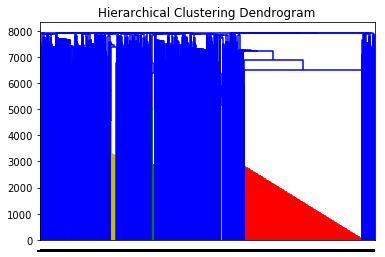

In [594]:
plt.title('Hierarchical Clustering Dendrogram')
plot_dendrogram(model, labels=model.labels_)
plt.show()

## KMeans

In [33]:
from sklearn.cluster import KMeans

model = KMeans(n_clusters=3, random_state=1)
preds = model.fit_predict(object_feature.toarray())
print(preds[:30])

[0 0 0 0 1 1 0 1 0 1 1 1 0 0 0 0 0 0 0 1 1 1 0 0 0 1 0 0 0 0]


In [34]:
## target value??


## SVD + KMeans

In [35]:
from sklearn.decomposition import TruncatedSVD

model = KMeans(n_clusters=3, random_state=42)
svd = TruncatedSVD(n_components=1000, random_state=123)
features = svd.fit_transform(object_feature)
preds = model.fit_predict(features)
print(preds)

[1 1 1 ..., 1 1 1]


Предобработка

In [26]:
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer

In [28]:
ps = PorterStemmer()
lemmatizer = WordNetLemmatizer()

In [ ]:
for elem in word_tokenize(str(texts[1])):
    print(elem, ps.stem(elem))

In [ ]:
X = []
for elem in texts:
    X.append(word_tokenize(elem))
    for j in range(len(X[i])):
        X[i][j] = PorterStemmer().stem(X[i][j])
    X[i] = " ".join(X[i])